# Setup directories and dataset

In [1]:
%pwd
%mkdir SelfieDetector
%cd SelfieDetector/

/content/SelfieDetector


In [ ]:
%mkdir dataset
%cd dataset/
!gdown https://drive.google.com/uc?id=1_Tv6jlrhJdticqzrIqJXcLdm6thCYW3g
!unzip Selfie-Image-Detection-Dataset.zip
%rm Selfie-Image-Detection-Dataset.zip
%cd ../

In [3]:
%pwd

'/content/SelfieDetector'

# Checking the dataset distribution

In [4]:
import os, glob

In [5]:
dataset_path = "/content/SelfieDetector/dataset/"
print(f"Number of Test Samples: \
        \n\tSelfie: {len(os.listdir(os.path.join(dataset_path, 'Test_data/Selfie/')))} \
        \n\tNon-Selfie: {len(os.listdir(os.path.join(dataset_path, 'Test_data/NonSelfie/')))}")
print(f"Number of Training Samples: \
        \n\tSelfie: {len(os.listdir(os.path.join(dataset_path, 'Training_data/Selfie/')))} \
        \n\tNon-Selfie: {len(os.listdir(os.path.join(dataset_path, 'Training_data/NonSelfie/')))}")
print(f"Number of Validation Samples: \
        \n\tSelfie: {len(os.listdir(os.path.join(dataset_path, 'Validation_data/Selfie/')))} \
        \n\tNon-Selfie: {len(os.listdir(os.path.join(dataset_path, 'Validation_data/NonSelfie/')))}")
print(f"Total Number of Samples: {len(glob.glob(dataset_path + '**/*.jpg', recursive=True))}")

Number of Test Samples:         
	Selfie: 3931         
	Non-Selfie: 3931
Number of Training Samples:         
	Selfie: 38974         
	Non-Selfie: 23921
Number of Validation Samples:         
	Selfie: 3931         
	Non-Selfie: 3931
Total Number of Samples: 78619


# Importing requirements

In [6]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Resize, Compose, InterpolationMode, Normalize, RandomHorizontalFlip
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Setting up data paths

In [7]:
train_data_path = os.path.join(dataset_path, "Training_data")
valid_data_path = os.path.join(dataset_path, "Validation_data")
test_data_path = os.path.join(dataset_path, "Test_data")

# Visualize some random samples from dataset

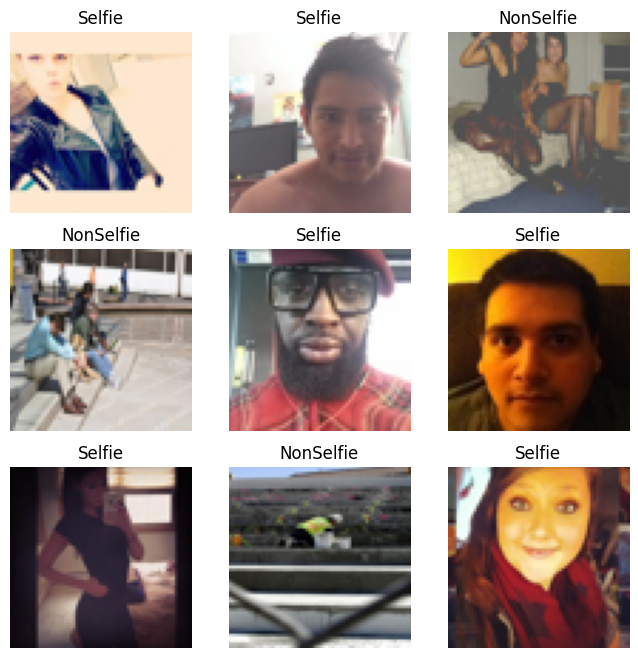

In [8]:
# Basic transform for sample visualization
train_img_size = 64
visualize_transforms = Compose([Resize(size=train_img_size, interpolation=InterpolationMode.BICUBIC),
                            ToTensor(),
                            ])

# Create dataset for visualization
train_dataset = datasets.ImageFolder(
    root=train_data_path,
    transform=visualize_transforms,
)

# Class annotations
classes = {
    0: "NonSelfie",
    1: "Selfie",
}

# Plot images on a 3by3 grid
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
  sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
  img, label = train_dataset[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(classes[label])
  plt.axis("off")
  plt.imshow(img.squeeze().permute(1,2,0), cmap="gray")
plt.show()

# Creating some utility functions and classes

In [9]:
def prepare_dataloaders(data_args, transforms):
  """
    Takes dataset arguments and creates dataloaders.
  """
  train_dataset = datasets.ImageFolder(
      root=data_args["train_data_path"],
      transform=transforms,
  )

  valid_dataset = datasets.ImageFolder(
      root=data_args["valid_data_path"],
      transform=transforms,
  )

  test_dataset = datasets.ImageFolder(
      root=data_args["test_data_path"],
      transform=transforms,
  )

  train_loader = DataLoader(train_dataset, batch_size=data_args["batch_size"], num_workers=data_args["num_workers"], shuffle=True)
  valid_loader = DataLoader(valid_dataset, batch_size=data_args["batch_size"], num_workers=data_args["num_workers"], shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=data_args["batch_size"], num_workers=data_args["num_workers"], shuffle=False)

  return train_loader, valid_loader, test_loader


class AverageMeter():
  """
    Keeps running loss and provides easy average computation.
  """
  def __init__(self):
    self.running_sum = 0
    self.count = 0

  def add(self, metric):
    self.running_sum += metric
    self.count += 1

  def log(self):
    avg = self.running_sum / self.count
    self.count, self.running_sum = 0, 0
    return avg

# Model Creation

In [10]:
# This is LayerNorm2d module used in the original ConvNeXt implementation,
# see https://github.com/pytorch/vision/blob/main/torchvision/models/convnext.py#L30
class LayerNorm2d(nn.LayerNorm):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.permute(0, 2, 3, 1)
        x = F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        x = x.permute(0, 3, 1, 2)
        return x

# Pre-trained ConvNeXt Tiny model, which was trained on ImageNet1K, is loaded from torch
model = convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
# Changed the classification layer with our own classifier with 2 outputs (selfie, non-selfie)
model.classifier = torch.nn.Sequential(LayerNorm2d((768,), eps=1e-06, elementwise_affine=True),
                                       nn.Flatten(start_dim=1, end_dim=-1),
                                       nn.Linear(in_features=768, out_features=2, bias=True),
                                       )

# Freeze the feature extractor layer so that we only train the last classifier layer
for name, param in model.features.named_parameters():
  param.requires_grad = False

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 129MB/s]


# Prepare for training


*   Create data config
*   Create transformations
*   Prepare dataloaders
*   Set the optimization/training config
*   Creater optimizer and loss functions



In [11]:
# Data config
imagenet_mean = torch.tensor([0.485, 0.456, 0.406])
imagenet_std = torch.tensor([0.229, 0.224, 0.225])
train_image_size = 64
batch_size = 128
num_workers = 2
data_args = {"batch_size": batch_size,
             "num_workers": num_workers,
             "train_data_path": train_data_path,
             "valid_data_path": valid_data_path,
             "test_data_path": test_data_path}

# Transformation for training
transforms = Compose([Resize(size=train_img_size, interpolation=InterpolationMode.BICUBIC),
                    RandomHorizontalFlip(p=0.5),
                    ToTensor(),
                    Normalize(imagenet_mean, imagenet_std),
                    ])

# Prepare dataloaders
train_loader, valid_loader, test_loader = prepare_dataloaders(data_args, transforms)

# Optimization config
lr = 1e-3
lr_min = 0.0
weight_decay = 0.05
epochs = 1
valid_interval = 1

# Send model to GPU
model.cuda()
# Create optimizer, lr_scheduler, and CE Loss
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=lr_min)
criterion = nn.CrossEntropyLoss()

# Training

In [12]:
# loss tracker
loss_meter = AverageMeter()

# train loop
for epoch in range(epochs):
  # turn train mode
  model.train()
  for imgs, labels in tqdm(train_loader):
    # Prepare inputs
    imgs = imgs.cuda()
    labels = F.one_hot(labels, num_classes=2).type(torch.FloatTensor).cuda()

    # Reset gradients
    optimizer.zero_grad()

    # Forward pass + loss + backward pass
    outputs = model(imgs)
    loss = criterion(outputs, labels)
    loss.backward()

    # update weights
    optimizer.step()

    # track loss
    loss_meter.add(loss.item())

  print(f"[{epoch + 1}/{epochs}] Loss: {loss_meter.log():.4f}")

  # validation
  if (epoch+1) % valid_interval == 0:
    # turn eval mode
    model.eval()
    total_preds = 0
    true_preds = 0
    print("Validation_______________________")
    with torch.no_grad():
      for imgs, labels in tqdm(valid_loader):
        # prepare input and get the predictions
        imgs = imgs.cuda()
        outputs = model(imgs)
        _, predictions = torch.max(outputs, 1)

        # sum number of predictions (TP+TN+FP+FN) and true predictions (TP+TN)
        total_preds += len(labels)
        true_preds += torch.sum(labels == predictions.detach().cpu())

    # calculate accuracy
    accuracy = 100 * true_preds / total_preds
    print(f'Validation Accuracy: {accuracy:.2f} %')

100%|██████████| 492/492 [02:10<00:00,  3.77it/s]


[1/1] Loss: 0.0938
Validation_______________________


100%|██████████| 62/62 [00:16<00:00,  3.78it/s]

Validation Accuracy: 97.33 %


# Testing
## Compute accuracy over the entire test data

In [13]:
# turn eval mode
model.eval()
total_preds = 0
true_preds = 0
print("Testing_______________________")
with torch.no_grad():
  for imgs, labels in tqdm(test_loader):
    # prepare input and get the predictions
    imgs = imgs.cuda()
    outputs = model(imgs)
    _, predictions = torch.max(outputs, 1)

    # sum number of predictions (TP+TN+FP+FN) and true predictions (TP+TN)
    total_preds += len(labels)
    true_preds += torch.sum(labels == predictions.detach().cpu())

# calculate accuracy
accuracy = 100 * true_preds / total_preds
print(f'Testing Accuracy: {accuracy:.2f} %')

Testing_______________________


100%|██████████| 62/62 [00:16<00:00,  3.87it/s]

Testing Accuracy: 97.91 %


# Perform testing on random samples

In [14]:
# turn eval mode
model.eval()

# create test dataset without transformation
test_dataset = datasets.ImageFolder(
      root=data_args["test_data_path"],
  )

# result containers
gt_list = []
pred_list = []
img_list = []

# random samples
numSamples = 16
random_sample_idxs = torch.randint(0, len(test_dataset)-1, (numSamples,))

# loop over random samples
for i in random_sample_idxs:
  # get the original and transformed sample
  test_img, test_label = test_dataset[i]
  transformed_img = transforms(test_img).cuda()
  # perform inference
  with torch.no_grad():
    outputs = model(transformed_img.unsqueeze(0))
    _, prediction = torch.max(outputs.detach().cpu(), 1)
  # collect results
  gt_list.append(classes[test_label])
  pred_list.append(classes[prediction.item()])
  img_list.append(test_img)

# Visualize results

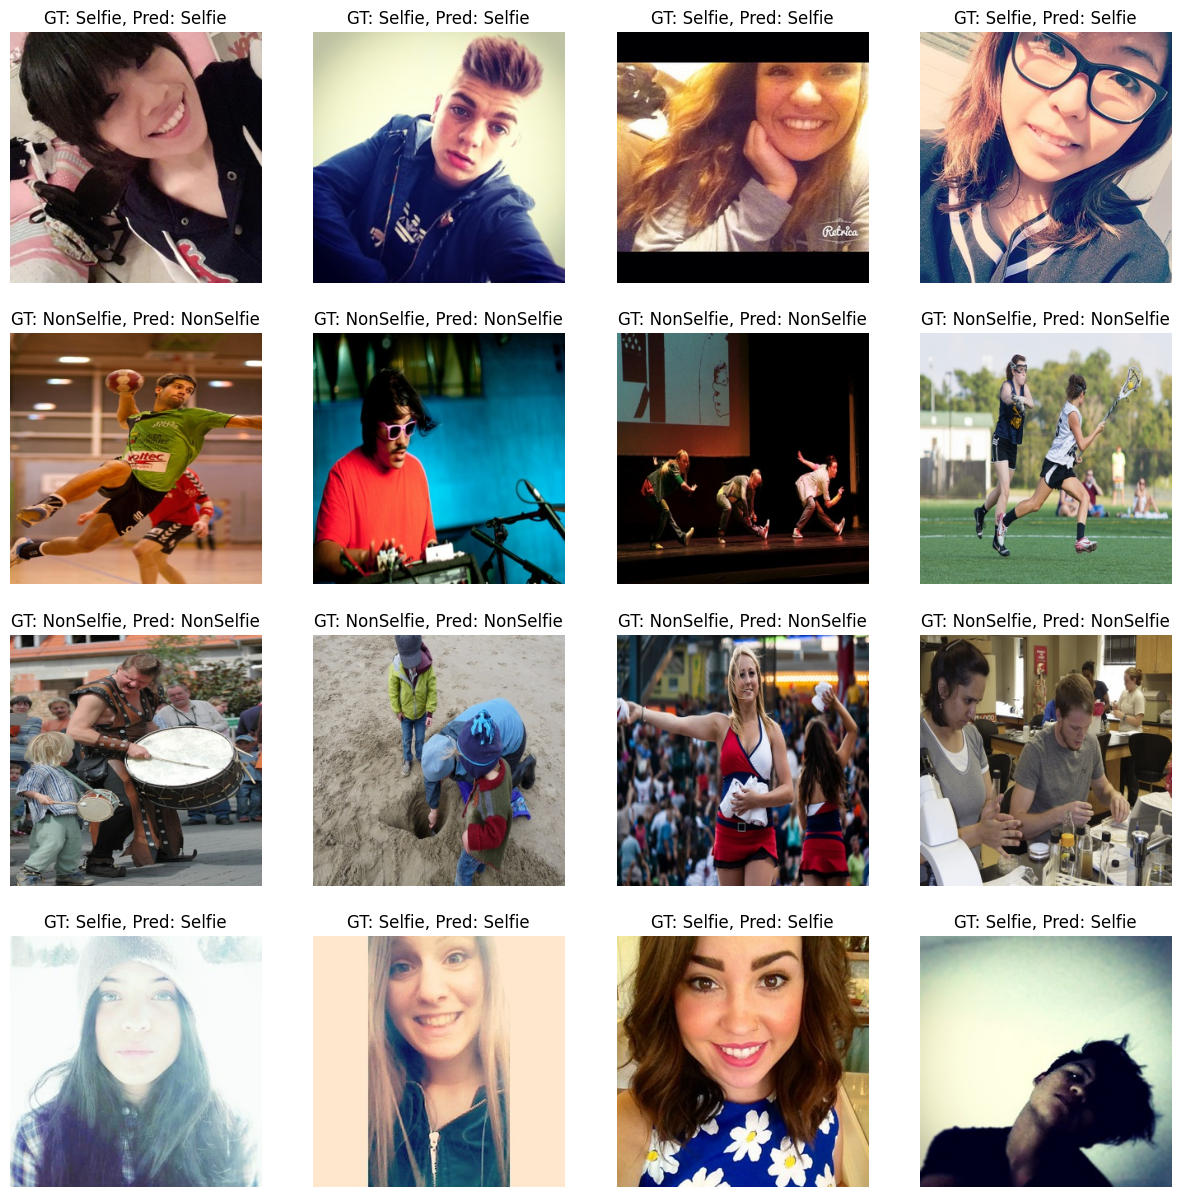

In [15]:
figure = plt.figure(figsize=(15, 15))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
  label = gt_list[i-1]
  pred = pred_list[i-1]
  img = img_list[i-1]

  figure.add_subplot(rows, cols, i)
  plt.title(f"GT: {label}, Pred: {pred}")
  plt.axis("off")
  plt.imshow(img, cmap="gray")

plt.show()

# Save model in compiled script format

In [16]:
model_scripted = torch.jit.script(model.cpu())
model_scripted.save('model_scripted.pt')